In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmocean.cm as cm
import datetime as dt
from matplotlib.colors import LogNorm
from salishsea_tools import viz_tools
import os

In [2]:
cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

### Import functions

In [21]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return 1 - (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())
    
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

def wolfram_perp2( obs, mod):
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * obs
    
    nonsyst = np.sqrt(((mod - predictions)**2).mean())
    systematic = np.sqrt(((predictions - obs)**2).mean())
  
    return a1, b1, systematic, nonsyst

def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5)  ]
# bad onc data
 #   temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
# bad ferry data
  #  temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
  #                                   & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    return temp1_nohook

def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    print (temp1[temp1.k <= idepth])
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    print (swillmott(select, 'LCEWEL01', 'mod_vozocrtx'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.01)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    # ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    # ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    # ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    # ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

def get_stats(temp1, name, idepth, jdepth, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    # print (swillmott(select, 'LCEWEL01', 'mod_vozocrtx'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    xr = np.arange(vmin, vmax, 0.01)
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh

    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}

    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2



def get_combined(years, years_og, years_ios, idepth, jdepth, whichdepths, reverse=False,gridN='None',straitn='_'):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        if gridN=='gridV':
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/OAE/sss150/ModelEval/ObsModel/ObsModel_sss150_csv_gridV_{year}0301_{year}0306.csv')
        else:
            pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/OAE/sss150/ModelEval/ObsModel/ObsModel_sss150_csv_gridU_{year}0301_{year}0306.csv')
    for year in years_og:
        file_path1 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0101_{year}1231.csv'
        file_path2 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0101_{year}0331.csv'
        file_path3 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0401_{year}1031.csv'
        file_path4 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}1001_{year}1231.csv'
        file_path5 = f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_onc_gridU_OG_{year}0101_{year}0430.csv'

        if os.path.exists(file_path1):
            pieces1.append(file_path1)

        if os.path.exists(file_path2):
            pieces1.append(file_path2)

        if os.path.exists(file_path3):
            pieces1.append(file_path3)

        if os.path.exists(file_path4):
            pieces1.append(file_path4)

        if os.path.exists(file_path5):
            pieces1.append(file_path5)
        
    for year in years_ios:

            file_path = f'/ocean/cstang/MOAD/analysis-camryn/OAE/sss150/ModelEval/ObsModel/ObsModel_sss150_CIOOS_{year}0301_{year}0331.csv'
            print(file_path)
            if os.path.exists(file_path):
                pieces1.append(file_path)
            else:
                print('nay')
            
    temp1 = read_pieces(pieces1)
    # data_filter = temp1[temp1[modn].notna()]
    # print(data_filter)
    d202111 = get_stats(filter_bad_data(temp1),field , idepth, jdepth, whichdepths, reverse, string)
    
    return temp1,d202111

In [23]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

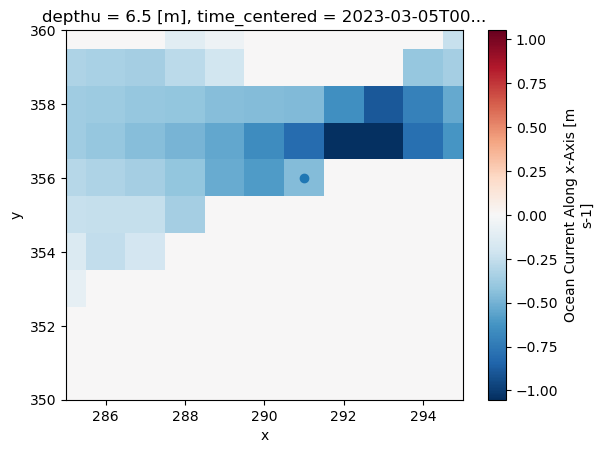

In [5]:
uvel_sss150 = xr.open_dataset('/data/cstang/MEOPAR/results/sss150/05mar23/sss150_1h_20230305_20230305_grid_U.nc')

uvel_sss150.vozocrtx[0,6].plot()
plt.ylim(350,360)
plt.xlim(285,295)
plt.scatter(291,356)

#### Import data

In [55]:
data = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/OAE/sss150/ModelEval/ObsModel/ObsModel_sss150_csv_gridV_20230301_20230303.csv')
mesh = xr.open_dataset('/ocean/mdunphy/SSS150/grid/mesh_mask_southsalishsea150_update202108210102AUM1.nc')

### Plot

In [36]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 15
vmin = 0
dbin = 0.3
scale = 24

idepth = 0
jdepth = 39
theta_sym = '\u03B8'

data_temp,d_temp = get_combined([],[], [2023]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')

d_temp.style.format(myformat).apply(highlight_max_min)

/ocean/cstang/MOAD/analysis-camryn/OAE/sss150/ModelEval/ObsModel/ObsModel_sss150_CIOOS_20230301_20230331.csv


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,1966,0.717,0.77,0.281,0.753,-0.2,-0.934,0.728,0.282,-0.404


In [33]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 20
dbin = 0.3
scale = 24

idepth = 0
jdepth = 39

data_sal,d_sal = get_combined([],[], [2023]#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')

d_sal.style.format(myformat).apply(highlight_max_min)

/ocean/cstang/MOAD/analysis-camryn/OAE/sss150/ModelEval/ObsModel/ObsModel_sss150_CIOOS_20230301_20230331.csv


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,1966,-0.254,0.42,0.335,0.93,-0.284,-8.9,0.323,0.316,-0.598


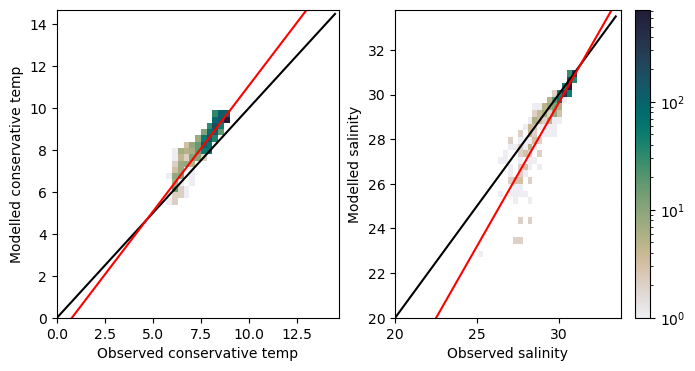

In [42]:
fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))

field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 15
vmin = 0
dbin = 0.3
scale = 24

idepth = 0
jdepth = 39
counts, xedges, yedges, color = ax.hist2d(data_temp['consT'],data_temp['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax.set_xlabel(f'Observed conservative temp')
ax.set_ylabel(f'Modelled conservative temp')
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(data_temp,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 20
dbin = 0.3
scale = 24

idepth = 0
jdepth = 39

counts, xedges, yedges, color = ax2.hist2d(data_sal['SA'],data_sal['mod_vosaline'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
# ax.set_xlabel(f'Observed {theta_sym}')
# ax.set_ylabel(f'Modelled {theta_sym}')
ax2.set_xlabel(f'Observed salinity')
ax2.set_ylabel(f'Modelled salinity')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(data_sal,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax2.plot(np.arange(vmin, vmax, 0.5),line,'r')

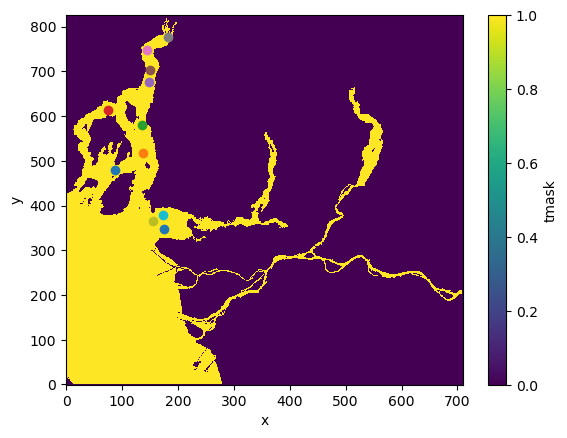

In [64]:
mesh.tmask[0,0].plot()

for i in range(11):
    plt.scatter(data_sal.i.unique()[i],data_sal.j.unique()[i])

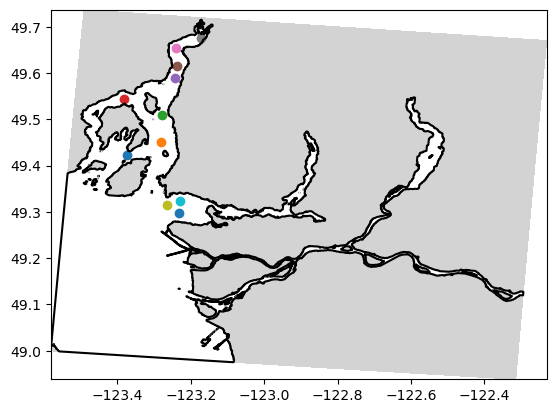

In [67]:
fig,ax = plt.subplots()

ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k',zorder=2)

for i in range(11):
    plt.scatter(data_sal.Lon.unique()[i],data_sal.Lat.unique()[i])